
<p align="center"><img src='https://drive.google.com/uc?export=view&id=1OXFXgJ990sl5sXpEh-9C8MHKZtJ45dkd'></p>

# 1 Preliminary

## 1.1 Context

L’Organisation nationale de lutte contre le faux-monnayage (ONCFM) est une organisation publique ayant pour objectif de mettre en place des méthodes d’identification des contrefaçons des billets en euros. Dans ce cadre, le présent notebook propose un algorithme qui derva être capable de différencier automatiquement les vrais des faux billets. 

L'algorithme met en concurrence trois méthodes de prédiction :
- une régression logistique classique ;
- une méthode des k plus proches voisins (K-NN) ;
- un k-means, duquel seront utilisés les centroïdes pour réaliser la prédiction.

Cet algorithme se devra d’être naturellement le plus performant possible pour identifier un maximum de faux billets.


## 1.2 Libraries

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor

import scipy.stats as st

import statsmodels.api as sm

import matplotlib.pyplot as plt

import seaborn as sns

## 1.3 Options

In [ ]:
# Modifier un parametrage du pandas
pd.options.display.max_columns=999
# Afficher des décimaux sans format scientifique
pd.options.display.float_format = '{:.3f}'.format
# Identifier les valeurs qui seront considérées comme nulles
missing_values = ["n/a", "na", "--","nan","NaN", "NaT", " ", ""]

## 1.4 Functions

In [ ]:
def dagostino_test(df, alpha):
  print(f"Test de D’Agostino et Pearson (alpha = {alpha}) \n")
  for col in df.columns:
    s2k2, p = st.normaltest(df[col])
    print(f'Variable : {col}')
    print(f'Résultat : S2 + K2 = {round(s2k2, 4)}, p-value = {round(p, 4)}')
    if p > alpha:
      print('Interprétation : la distribution semble normale (gaussienne) \n')
    else:
      print('Interprétation : la distribution semble anormale (non gaussienne) \n')

In [ ]:
def shapiro_test(df, alpha):
  print(f"Test de Shapiro-Wilk (alpha = {alpha}) \n")
  for col in df.columns:
    w, p = st.shapiro(df[col])
    print(f'Variable : {col}')
    print(f'Résultat : w = {round(w, 4)}, p-value = {round(p, 4)}')
    if p > alpha:
      print('Interprétation : la distribution semble normale (gaussienne) \n')
    else:
      print('Interprétation : la distribution semble anormale (non gaussienne) \n')

In [ ]:
# Cette fonction est intégralement copiée du cours Réalisez une analyse exploratoire de données
def correlation_graph(pca, 
                      x_y, 
                      features, 
                      figsize=[6, 6]) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x, y = x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=figsize)

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # le titre
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show()

# 2 Data Preparation

## 2.1 Data Loading

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OC-DAN/P10/billets.csv", sep = ';', na_values = missing_values)

## 2.2 Data Overview

In [ ]:
data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.810,104.860,104.950,4.520,2.890,112.830
1,True,171.460,103.360,103.660,3.770,2.990,113.090
2,True,172.690,104.480,103.500,4.400,2.940,113.160
3,True,171.360,103.910,103.940,3.620,3.010,113.510
4,True,171.730,104.280,103.460,4.040,3.480,112.540


In [ ]:
data.tail()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1495,False,171.750,104.380,104.170,4.420,3.090,111.280
1496,False,172.190,104.630,104.440,5.270,3.370,110.970
1497,False,171.800,104.010,104.120,5.510,3.360,111.950
1498,False,172.060,104.280,104.060,5.170,3.460,112.250
1499,False,171.470,104.150,103.820,4.630,3.370,112.070


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


## 2.3 Data Cleaning

Vérifions s'il y a des doublons

In [ ]:
data.duplicated().sum()

0

Vérifions s'il y a des valeurs nulles

In [ ]:
data.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

On voit que la variable margin_low contient 37 valeurs nulles. On va éventuellement faire une imputation par régression linéaire. On stocke tout d'abord ces valeurs dans un nouveau dataframe pour l'imputation. On crée aussi un autre dataframe pour stocker une copie sans les valeurs nulles.

In [ ]:
missing_values = data[data['margin_low'].isna()].copy()

In [ ]:
df = data.dropna()
df.shape

(1463, 7)

Vérification de la variable is_genuine

In [ ]:
data.is_genuine.unique()

array([ True, False])

In [ ]:
data.is_genuine.value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

# 3 Data Analysis

In [ ]:
df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1463.000,1463.000,1463.000,1463.000,1463.000,1463.000
mean,171.959,104.031,103.921,4.486,3.153,112.675
std,0.305,0.300,0.324,0.664,0.231,0.873
min,171.040,103.140,102.910,2.980,2.270,109.490
25%,171.750,103.825,103.710,4.015,2.990,112.020
50%,171.960,104.040,103.920,4.310,3.140,112.960
75%,172.170,104.230,104.150,4.870,3.315,113.340
max,173.010,104.880,104.950,6.900,3.910,114.320


## 3.1 Univariate Analysis

**Outliers Check**

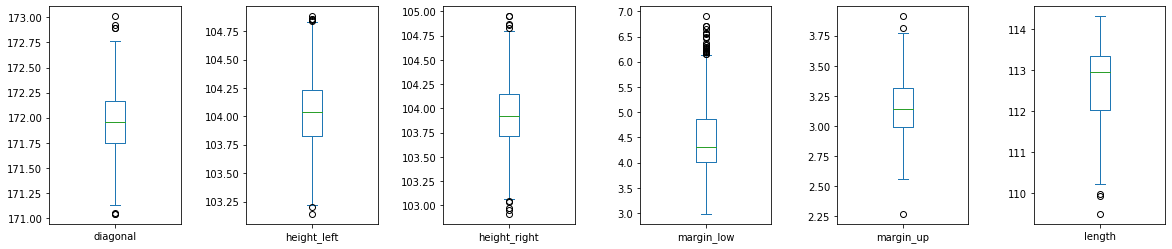

In [ ]:
df.plot(kind='box', subplots=True, layout=(1, 6), figsize=(20, 4))
plt.subplots_adjust(wspace=0.5)
plt.show()

In [ ]:
col = 'margin_low'
q1 = df[col].quantile(0.25) # Calculer le premier quartile Q1
q3 = df[col].quantile(0.75) # Calculer le troisième quartile Q3
iqr = q3 - q1 # Calculer l'écart interquartile IQR
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index.to_list()
print(f'la variable {col} contient {len(outliers)} outlier(s)')

la variable margin_low contient 24 outlier(s)


**Normality Test**

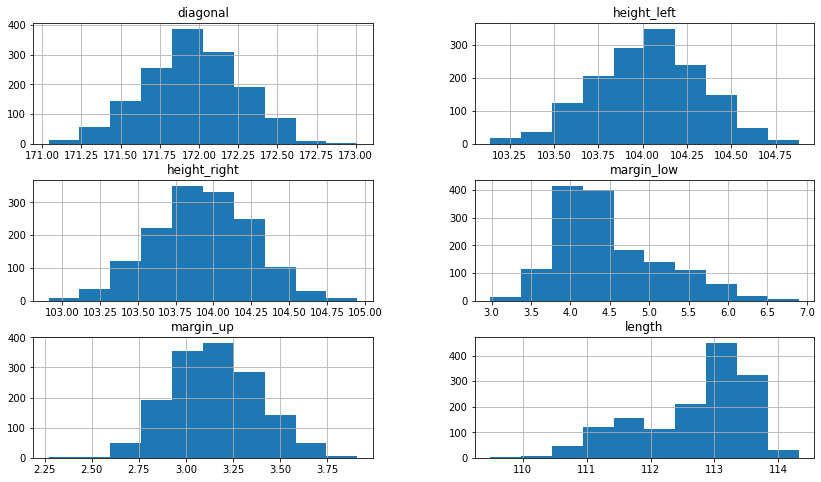

In [ ]:
df.hist(figsize=(14, 8))
plt.show()

In [ ]:
dagostino_test(df, 0.05)

Test de D’Agostino et Pearson (alpha = 0.05) 

Variable : is_genuine
Résultat : S2 + K2 = 9457.6678, p-value = 0.0
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : diagonal
Résultat : S2 + K2 = 1.4345, p-value = 0.4881
Interprétation : la distribution semble normale (gaussienne) 

Variable : height_left
Résultat : S2 + K2 = 4.6541, p-value = 0.0976
Interprétation : la distribution semble normale (gaussienne) 

Variable : height_right
Résultat : S2 + K2 = 0.2035, p-value = 0.9033
Interprétation : la distribution semble normale (gaussienne) 

Variable : margin_low
Résultat : S2 + K2 = 142.2784, p-value = 0.0
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : margin_up
Résultat : S2 + K2 = 11.1124, p-value = 0.0039
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : length
Résultat : S2 + K2 = 134.7089, p-value = 0.0
Interprétation : la distribution semble anormale (non gaussienne) 



In [ ]:
shapiro_test(df, 0.05)

Test de Shapiro-Wilk (alpha = 0.05) 

Variable : is_genuine
Résultat : w = 0.5964, p-value = 0.0
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : diagonal
Résultat : w = 0.9986, p-value = 0.2687
Interprétation : la distribution semble normale (gaussienne) 

Variable : height_left
Résultat : w = 0.9979, p-value = 0.0576
Interprétation : la distribution semble normale (gaussienne) 

Variable : height_right
Résultat : w = 0.9994, p-value = 0.9576
Interprétation : la distribution semble normale (gaussienne) 

Variable : margin_low
Résultat : w = 0.9378, p-value = 0.0
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : margin_up
Résultat : w = 0.9958, p-value = 0.0005
Interprétation : la distribution semble anormale (non gaussienne) 

Variable : length
Résultat : w = 0.9163, p-value = 0.0
Interprétation : la distribution semble anormale (non gaussienne) 



## 3.2 Multivariate Analysis

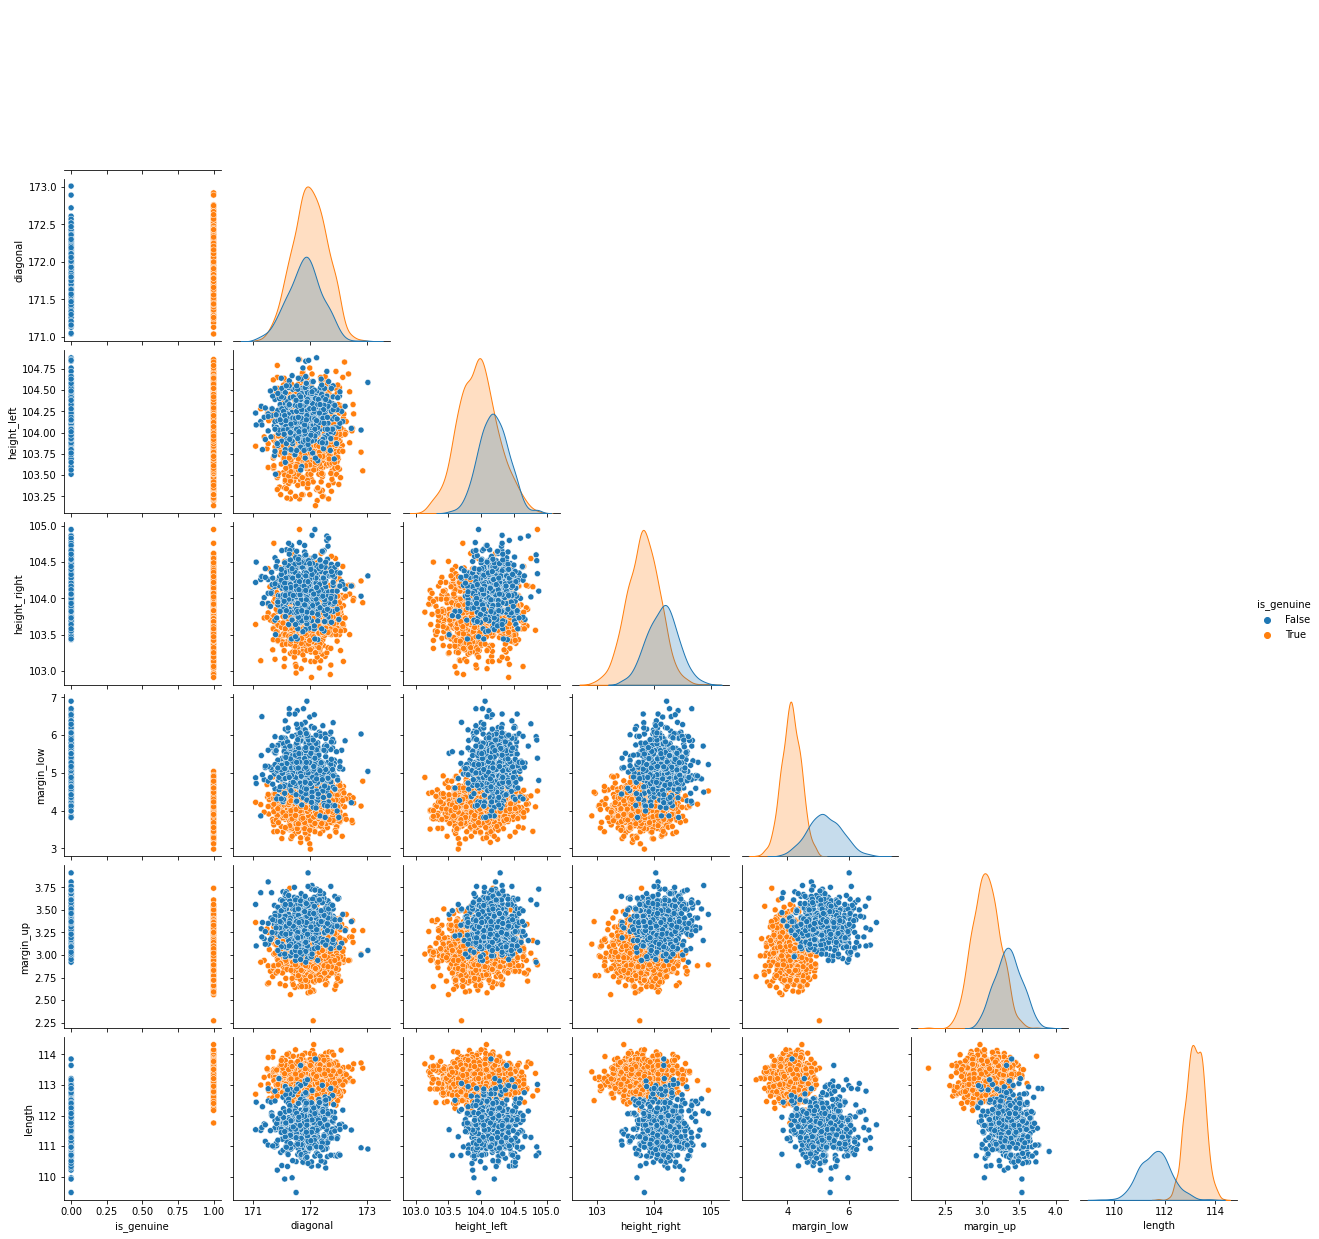

In [ ]:
sns.pairplot(data=df, vars=df.columns, hue=('is_genuine'), corner=True)
plt.show()

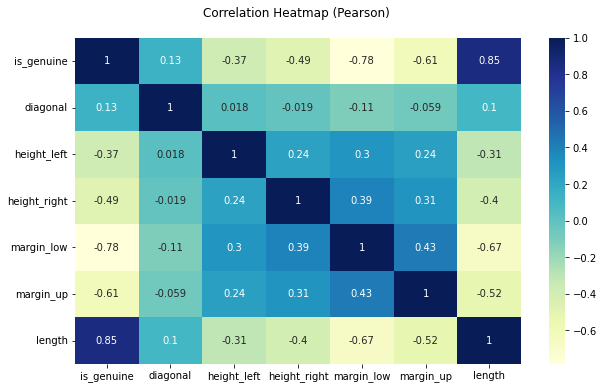

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(method='pearson'), annot=True, cmap='YlGnBu')
plt.title("Correlation Heatmap (Pearson) \n")
plt.show()

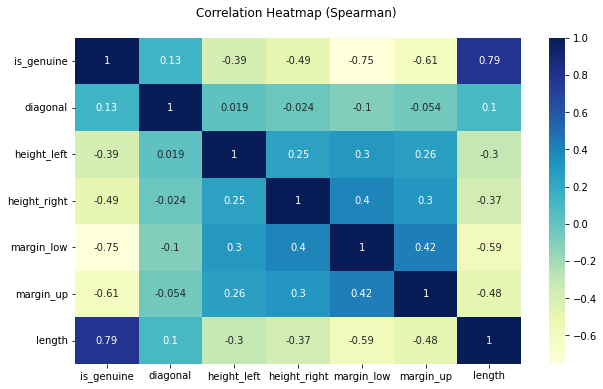

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(method='spearman'), annot=True, cmap='YlGnBu')
plt.title("Correlation Heatmap (Spearman) \n")
plt.show()

## 3.2 Principal Component Aanalysis (PCA)

**Data Split**

In [ ]:
pca_df = df.drop(columns='is_genuine')
cluster = df['is_genuine'].values

In [ ]:
X = pca_df.values
features = pca_df.columns
indexes = pca_df.index

**Scaling**

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [ ]:
idx = ["mean", "std"]
pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5
mean,0.000,0.000,0.000,0.000,-0.000,-0.000
std,1.000,1.000,1.000,1.000,1.000,1.000


**PCA Implementation**

In [ ]:
pca = PCA()
pca.fit(X_scaled)

PCA()

**Explained variance & scree plot**

In [ ]:
pca.explained_variance_ratio_

array([0.43123527, 0.16970651, 0.13136423, 0.11792169, 0.0962036 ,
       0.0535687 ])

In [ ]:
scree = (pca.explained_variance_ratio_ * 100).round(2)
scree

array([43.12, 16.97, 13.14, 11.79,  9.62,  5.36])

In [ ]:
scree_cum = scree.cumsum().round()
scree_cum

array([ 43.,  60.,  73.,  85.,  95., 100.])

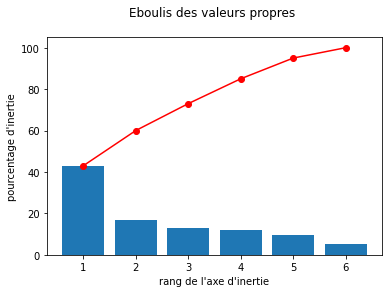

In [ ]:
x_list = range(1, len(scree)+1)
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres \n")
plt.show()

**Components**

In [ ]:
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]

**Correlation graph**

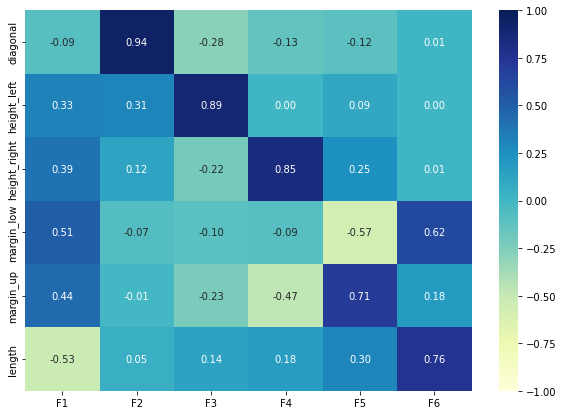

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="YlGnBu", fmt="0.2f")
plt.show()

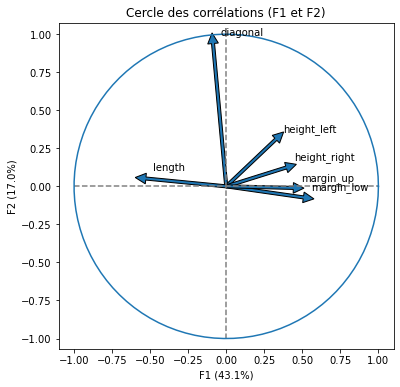

In [ ]:
x_y = (0, 1)
correlation_graph(pca, x_y, features)

Sur le premier plan factoriel, on voit que les variables les plus corrélées positivement à F1 sont :
- margin low
- margin up
- height right
- height left

On voit également que la variable length a une corrélation négative à F1. Cela confirme ce que la matrice de corrélation ci-avant a dèjà montré. 

Quant à F2, celui-ci est largement dominé par la variable diagonal.

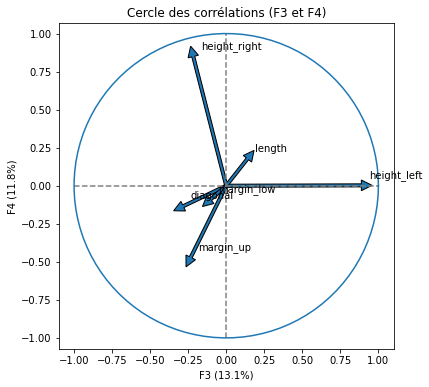

In [ ]:
x_y = (2, 3)
correlation_graph(pca, x_y, features)

Sur le deuxième plan factoriel, on voit que la variable right_left domine largement F3 avec une petite présence de la variable diagonal qui est anticorrélée. F4 est largement dominé par la varialbe height_right. On voit aussi que la variable margin_up est anticorrélée à F4.

**Projection**

In [ ]:
X_proj = pca.transform(X_scaled)

In [ ]:
pca_df = pd.DataFrame(X_proj)
pca_df.index = indexes
pca_df.columns = [f"F{i}" for i in range(1, 7)]
pca_df.head()

,F1,F2,F3,F4,F5,F6
0,1.627,0.807,2.193,3.329,0.329,0.002
1,-2.017,-2.218,-1.012,0.043,0.044,-0.468
2,-0.996,2.596,1.242,-0.879,-0.869,0.185
3,-1.380,-1.810,0.595,0.890,0.805,-0.213
4,0.138,-0.597,0.976,-1.738,1.147,-0.296


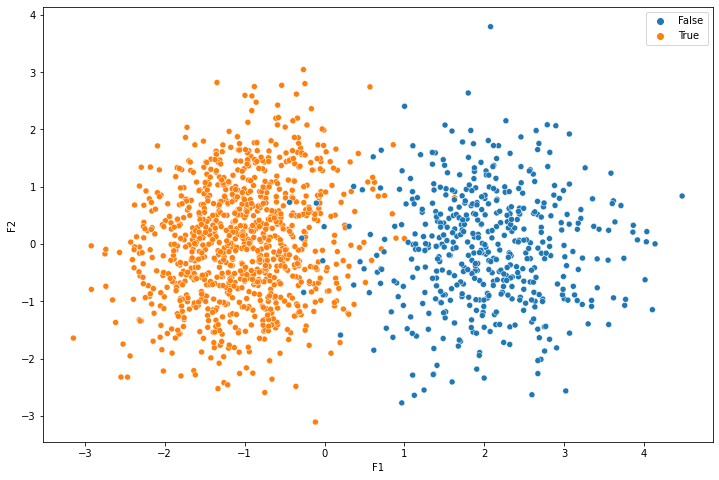

In [ ]:
plt.figure(figsize = (12, 8))
sns.scatterplot(x = pca_df["F1"], y = pca_df['F2'], hue = cluster)
plt.show()

# 4 Linear Regression

In [ ]:
lr_model = LinearRegression()

In [ ]:
lr_df = df.drop(columns='is_genuine')

In [ ]:
lr_df.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.810,104.860,104.950,4.520,2.890,112.830
1,171.460,103.360,103.660,3.770,2.990,113.090
2,172.690,104.480,103.500,4.400,2.940,113.160
3,171.360,103.910,103.940,3.620,3.010,113.510
4,171.730,104.280,103.460,4.040,3.480,112.540


In [ ]:
lr_df.shape

(1463, 6)

## 4.1 Feature Selection

Les variables inutiles augmentent la complexité du modèle de prédiction. Il veut mieux donc de n'avoir que celles les plus significatives et de garder le modèle simple pour obtenir le meilleur résultat. Pour sélectionner les variables les plus importantes, on va utiliser deux approches : Backward Elimination and Recursive Feature Elimination with Cross-Validation (RFECV)

In [ ]:
input = ['length', 'margin_up', 'height_right', 'height_left', 'diagonal']
output = 'margin_low'

X = lr_df[input].values
y = lr_df[output].values

**Backward Elimination**

La technique d'élimination en arrière "Backward Elimination" est utilisée pour sélectionner le meilleur sous-ensemble de variables prédictives à partir d'un ensemble de variables donné. Cela fonctionne en supprimant de manière itérative la variable qui a le moins de pouvoir prédictif. Pendant chaque itération, on calcule la p-value pour toutes les variables, ensuite, on compare la p-value la plus haute à un seuil déjà fixé (normalement 0.05). Si la p-value est supérieure au seuil, cela signifie que la variable en question n'est pas significative dans la prédiction et il veut mieux l'enlever.

L'élimination en arrière comprend les étapes suivantes :

- a) Fixer un seuil de signification (normalement 0,05) 
- b) Ajuster le modèle avec tous les prédicteurs possibles
- c) Sélectionner le prédicteur avec la p-value la plus élevée
  - Si p-value > 0.05, passer au d. Sinon, stop.
- d) Supprimer le prédicteur
- e) Ajustez le modèle sans cette variable et répétez l'étape c.

In [ ]:
X_opt = sm.add_constant(X, prepend=False)
lr_ols = sm.OLS(endog = y, exog = X_opt)
results = lr_ols.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Thu, 16 Mar 2023   Prob (F-statistic):          2.60e-202
Time:                        23:20:31   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.4091      0.018    -22.627      0.0

Dès la première itération, on remparque que presque toutes les variables ont la même importance, avec une p-value à zéro, ou très proche de zéro (0.007) comme la variable x5 dont la p-value reste inférieure à 0.05. Donc, garder toutes les variables semble l'option la plus pertinente. 

**Recursive feature elimination with cross-validation (RFECV)**

RFECV effectue une élimination récursive des variables dans une boucle de validation croisée pour trouver le nombre optimal de varialbes prédictives. RFECV nécessite un estimateur. Ici, on va utiliser Random Forest Classifier comme estimateur.

In [ ]:
estimator = RandomForestRegressor()
rfecv = RFECV(estimator, step=1, cv=5)
rfecv = rfecv.fit(X, y)

print("Nombre de variables à retenir : ", rfecv.n_features_)

Nombre de variables à retenir :  5


In [ ]:
for i, col in zip(range(lr_df[input].shape[1]), lr_df[input].columns):
  print(f'{col}, rang : {rfecv.ranking_[i]}, retenue : {rfecv.support_[i]}')


length, rang : 1, retenue : True
margin_up, rang : 1, retenue : True
height_right, rang : 1, retenue : True
height_left, rang : 1, retenue : True
diagonal, rang : 1, retenue : True


On voit que la méthode de RFECV nous propose aussi de garder toutes les varialbes prédictives (X). Cela valide donc la conclusion de la méthode de "Backward Eliimination"

## 4.2 Data Split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=610)

## 4.3 Model implementation

In [ ]:
lr_model.fit(x_train, y_train)

LinearRegression()

In [ ]:
accuracy = lr_model.score(x_test, y_test)
print(f'Précision du modèle : {accuracy}')

Précision du modèle : 0.5618172780380967


In [ ]:
print('Coeffecient : \n', lr_model.coef_)
print('Intercept : \n', lr_model.intercept_)

Coeffecient : 
 [-0.39172214  0.28318892  0.26364023  0.20787739 -0.09501348]
Intercept : 
 15.046723570831016


## 4.4 Model Evaluation

In [ ]:
r2 = lr_model.score(x_test, y_test)
print(f'Coefficient de détermination : {r2}')

Coefficient de détermination : 0.5618172780380967


In [ ]:
y_pred = lr_model.predict(x_test)

In [ ]:
for i in range(len(y_pred)):
  print(round(y_pred[i], 2), y_test[i])

3.94 4.11
4.02 4.32
4.29 4.46
4.26 3.92
5.12 5.2
5.27 5.04
4.19 4.11
4.41 3.9
4.29 3.59
4.86 5.55
4.11 4.15
4.02 3.76
4.14 3.9
4.13 3.66
5.35 5.56
4.14 3.66
4.01 3.96
4.28 4.68
4.68 4.23
4.29 3.55
4.04 4.55
4.06 4.19
4.37 3.95
5.55 5.96
3.93 4.05
4.26 4.16
4.22 4.02
4.25 4.06
5.17 4.86
4.25 4.14
4.11 3.69
5.46 4.77
5.06 4.94
3.94 4.14
4.19 4.83
5.45 5.97
4.69 5.33
4.24 4.05
5.08 4.64
4.4 3.64
5.83 5.39
3.97 4.66
4.26 4.41
5.29 6.7
4.4 4.42
4.66 5.34
5.02 5.47
3.99 4.38
4.43 3.91
5.16 6.19
4.1 3.74
4.07 3.64
4.29 4.89
4.26 3.71
5.51 5.23
4.25 4.09
4.22 4.72
4.33 3.77
4.4 3.99
4.32 4.22
4.2 4.12
4.86 5.13
3.86 3.84
4.73 4.95
4.99 5.6
4.22 4.28
4.26 4.5
5.17 4.87
5.03 5.75
5.5 5.62
4.15 3.98
4.19 4.09
3.93 4.0
5.35 5.28
5.22 5.66
4.17 4.08
4.3 4.01
4.16 3.77
4.48 3.98
4.05 3.77
4.38 4.22
4.25 4.15
4.99 4.21
4.23 3.62
4.04 4.14
4.79 4.69
3.82 4.36
4.26 4.11
3.89 4.31
4.89 4.95
5.18 4.63
3.9 4.01
5.24 5.38
4.23 4.07
5.08 5.61
5.15 5.69
4.11 4.29
5.28 5.46
4.24 4.4
3.95 4.91
4.16 4.44
5.05 4

## 4.5 Assumptions Check

**Linearity**

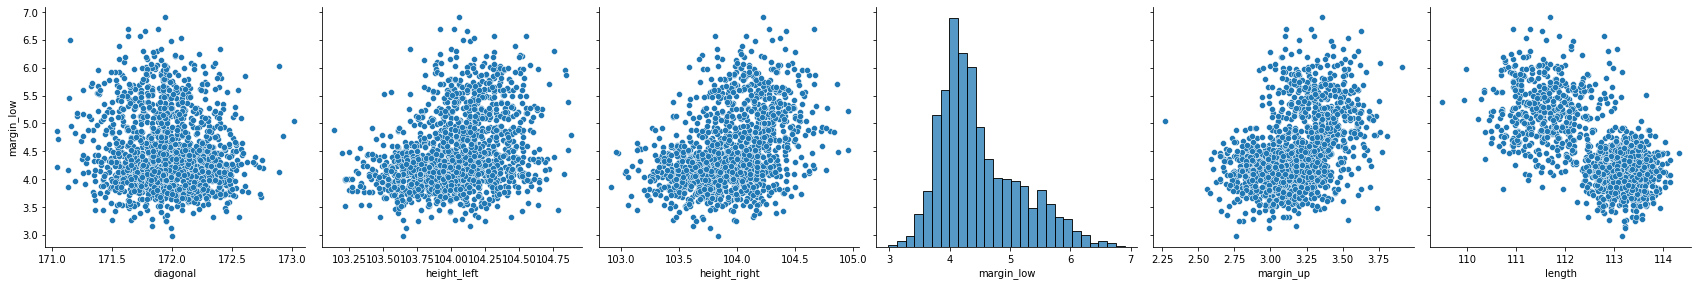

In [ ]:
sns.pairplot(lr_df, y_vars='margin_low', height=4)
plt.show()

In [ ]:
lr_df.corr()['margin_low']

diagonal       -0.112
height_left     0.303
height_right    0.391
margin_low      1.000
margin_up       0.432
length         -0.667
Name: margin_low, dtype: float64

On voit qu'il y a une rélation linéaire assez présente surtout entre la variable dépendante margin_low et la variable indépendante length. Il y a aussi une rélation linéaire faible entre la variable dépendante et les variables indépendantes margin_up et height_right. 

**Means of residuals**

Les résidus sont les différences entre la valeur réelle et la valeur prédite.

In [ ]:
residuals = y_test - y_pred

L'une des hypothèses de la régression linéaire est que la moyenne des résidus doit être nulle. Allons vérifier.

In [ ]:
mean_residuals = np.mean(residuals)
print(f'Moyenne des résidus : {mean_residuals}')

Moyenne des résidus : -0.008386865912765457


On voit que la moyenne des résidus est très petite (quasiment zéro). Donc, on est plutôt bon !

**Normality of Residuals**

Une autre hypothèse de la régression linéaire est que la distribution des résidus doit suivre la loi normale. Allons vérifier.

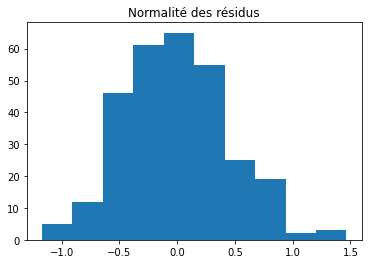

In [ ]:
plt.hist(residuals)
plt.title('Normalité des résidus')
plt.show()

Selon l'histogramme, la distribution des résidus semble normale. Allons la vérifier par des testes statistiques.

In [ ]:
s2k2, p = st.normaltest(residuals)
print(f'Résultat : S2 + K2 = {round(s2k2, 4)}, p-value = {round(p, 4)}')

Résultat : S2 + K2 = 4.7601, p-value = 0.0925


In [ ]:
w, p = st.shapiro(residuals)
print(f'Résultat : w = {round(w, 4)}, p-value = {round(p, 4)}')

Résultat : w = 0.9921, p-value = 0.1222


Les tests statistiques, avec une p-value > 0.05, valide bien la normalité de la distribution des résidus. 

**Homoscedasticity**

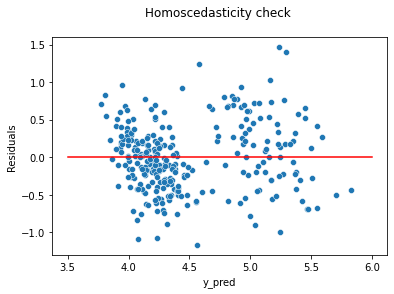

In [ ]:
sns.scatterplot(x=y_pred, y=residuals)
sns.lineplot(x=[3.5, 6], y=[0, 0], color='red')
plt.xlabel('y_pred')
plt.ylabel('Residuals')
plt.title('Homoscedasticity check \n')
plt.show()

Le nuage de points des résidus ne montre pas aucune tendance, c'est plutôt un signe positif.

**Residuals autocorrelation**

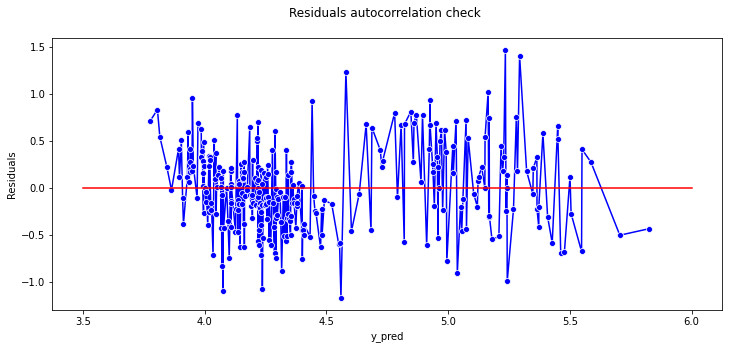

In [ ]:
plt.figure(figsize=(12, 5))
sns.lineplot(x=y_pred, y=residuals, marker='o', color='blue')
sns.lineplot(x=[3.5, 6], y=[0, 0], color='red')
plt.xlabel('y_pred')
plt.ylabel('Residuals')
plt.title('Residuals autocorrelation check \n')
plt.show()

Là aussi, on ne voit pas une mouvement ou une tendance particulière entre les résidus et les valeurs prédites. C'est un autre signe positif. 

## 4.6 Imputation

In [ ]:
missing_values.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.940,103.890,103.450,NaN,3.250,112.790
99,True,171.930,104.070,104.180,NaN,3.140,113.080
151,True,172.070,103.800,104.380,NaN,3.020,112.930
197,True,171.450,103.660,103.800,NaN,3.620,113.270
241,True,171.830,104.140,104.060,NaN,3.020,112.360


In [ ]:
missing_values[input].head()

,length,margin_up,height_right,height_left,diagonal
72,112.790,3.250,103.450,103.890,171.940
99,113.080,3.140,104.180,104.070,171.930
151,112.930,3.020,104.380,103.800,172.070
197,113.270,3.620,103.800,103.660,171.450
241,112.360,3.020,104.060,104.140,171.830


In [ ]:
X = np.array(missing_values[input])

In [ ]:
y_pred = lr_model.predict(X)
y_pred[:5]

array([4.31809324, 4.40416847, 4.41224338, 4.32586539, 4.64464168])

In [ ]:
data_clean = data.copy()

In [ ]:
data_clean.loc[data_clean['margin_low'].isna() == True, 'margin_low'] = y_pred

In [ ]:
data_clean.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

# 5 Logistic Regression

In [ ]:
lgr_model = LogisticRegression()

In [ ]:
lgr_df = data_clean.copy()

In [ ]:
lgr_df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.810,104.860,104.950,4.520,2.890,112.830
1,True,171.460,103.360,103.660,3.770,2.990,113.090
2,True,172.690,104.480,103.500,4.400,2.940,113.160
3,True,171.360,103.910,103.940,3.620,3.010,113.510
4,True,171.730,104.280,103.460,4.040,3.480,112.540


In [ ]:
lgr_df.shape

(1500, 7)

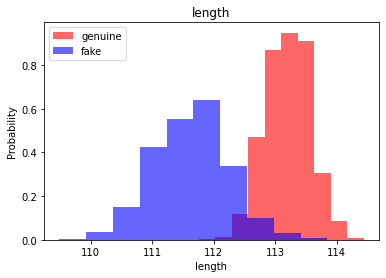

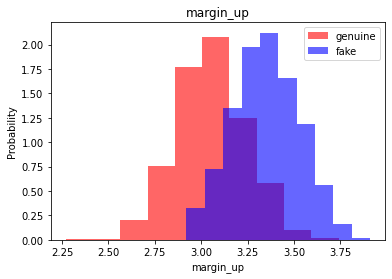

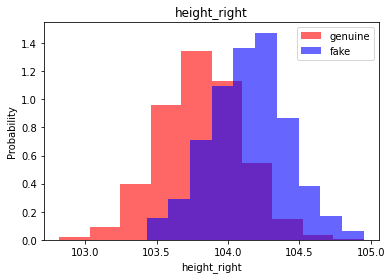

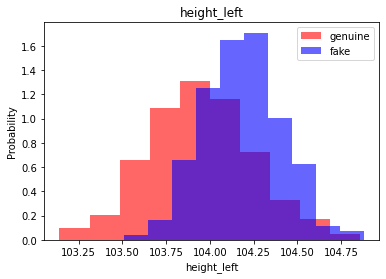

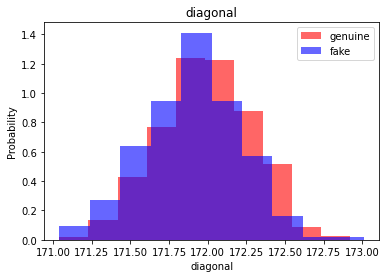

In [ ]:
for label in input:
  plt.hist(lgr_df[lgr_df['is_genuine'] == True][label], color='red', label='genuine', alpha=0.6, density=True)
  plt.hist(lgr_df[lgr_df['is_genuine'] == False][label], color='blue', label='fake', alpha=0.6, density=True)
  plt.title(label)
  plt.ylabel('Probability')
  plt.xlabel(label)
  plt.legend()
  plt.show()

## 5.1 Data Split

In [ ]:
input = ['length', 'margin_low', 'margin_up', 'height_right', 'height_left', 'diagonal'] 
output = 'is_genuine'

X = lgr_df[input].values
y = lgr_df[output].values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 82)

## 5.2 Model Implementation

In [ ]:
lgr_model.fit(x_train, y_train)

LogisticRegression()

In [ ]:
print('Coeffecient : \n', lgr_model.coef_)
print('Intercept : \n', lgr_model.intercept_)

Coeffecient : 
 [[ 3.69276864 -3.45268239 -3.14786323 -2.04786792 -1.44623541 -0.15025354]]
Intercept : 
 [-0.01919384]


## 5.3 Model Evaluation

In [ ]:
y_pred = lgr_model.predict(x_test)

In [ ]:
accuracy = lgr_model.score(x_test, y_test)
print(f'Précision du modèle : {accuracy}')

Précision du modèle : 1.0


In [ ]:
for i in range(len(y_pred)):
  print(y_pred[i], y_test[i])

True True
False False
True True
False False
True True
False False
True True
True True
True True
False False
True True
False False
True True
True True
True True
False False
True True
True True
True True
True True
True True
True True
True True
True True
True True
False False
False False
True True
True True
True True
True True
False False
True True
False False
False False
True True
True True
True True
True True
True True
True True
False False
True True
True True
False False
True True
False False
False False
True True
True True
True True
False False
True True
True True
False False
True True
True True
True True
True True
True True
True True
False False
True True
True True
False False
True True
True True
False False
False False
False False
True True
True True
True True
True True
True True
True True
False False
True True
False False
False False
False False
False False
True True
False False
False False
False False
True True
True True
True True
True True
False False
True True
False False
True T

In [ ]:
matches = 0
for i in range(len(y_pred)):
  if y_pred[i] == y_test[i]: 
    matches += 1
accuracy = matches / len(y_test)
print(matches, accuracy)

300 1.0


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00        87
        True       1.00      1.00      1.00       213

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



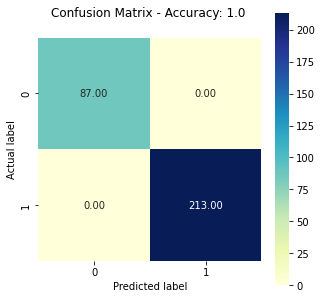

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt=".2f", square=True, cmap='YlGnBu');
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix - Accuracy: {accuracy} \n')
plt.show()

C'est parfait ! La précision du modèle de la régression logistique est à 100%. 

# 6 K-Nearest Neighbors (K-NN)

## 6.1 Determining K

In [ ]:
n_iterations = 10
scores = []
for i in range(1, n_iterations+1):
  knn_model = KNeighborsClassifier(n_neighbors=i)
  knn_model.fit(x_train, y_train)
  scores.append(knn_model.score(x_test, y_test))

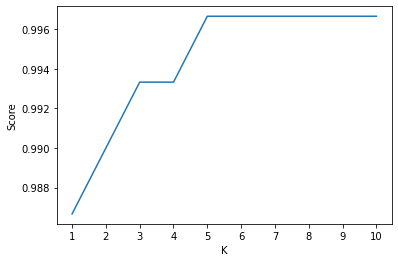

In [ ]:
plt.plot(range(1, n_iterations+1), scores)
plt.xticks(range(1, n_iterations+1))
plt.xlabel('K')
plt.ylabel('Score')
plt.show()

## 6.2 Model Implementation

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=5)

In [ ]:
knn_model.fit(x_train, y_train)

KNeighborsClassifier()

## 6.3 Model Evaluation

In [ ]:
accuracy = knn_model.score(x_test, y_test)
print(f'Précision du modèle : {accuracy}')

Précision du modèle : 0.9966666666666667


In [ ]:
y_pred = knn_model.predict(x_test)

In [ ]:
for i in range(len(y_pred)):
  print(y_pred[i], y_test[i])

True True
False False
True True
False False
True True
False False
True True
True True
True True
False False
True True
False False
True True
True True
True True
False False
True True
True True
True True
True True
True True
True True
True True
True True
True True
False False
False False
True True
True True
True True
True True
False False
True True
False False
False False
True True
True True
True True
True True
True True
True True
False False
True True
True True
False False
True True
False False
False False
True True
True True
True True
False False
True True
True True
False False
True True
True True
True True
True True
True True
True True
False False
True True
True True
False False
True True
True True
True False
False False
False False
True True
True True
True True
True True
True True
True True
False False
True True
False False
False False
False False
False False
True True
False False
False False
False False
True True
True True
True True
True True
False False
True True
False False
True Tr

In [ ]:
matches = 0
for i in range(len(y_pred)):
  if y_pred[i] == y_test[i]: 
    matches += 1
accuracy = matches / len(y_test)
print(matches, accuracy)

299 0.9966666666666667


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       1.00      0.99      0.99        87
        True       1.00      1.00      1.00       213

    accuracy                           1.00       300
   macro avg       1.00      0.99      1.00       300
weighted avg       1.00      1.00      1.00       300



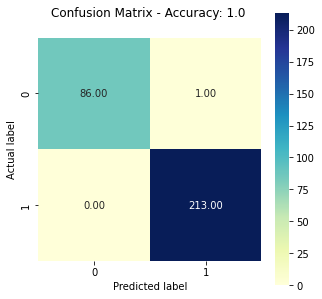

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt=".2f", square=True, cmap='YlGnBu');
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix - Accuracy: {round(accuracy, 2)} \n')
plt.show()

C'est presque parfait avec une précision à 99%, mais le modèle n'est pas très fiable. En effet, le seule erreur est un peu problématique car le modèle de K-NN a identifié un faux billet comme vrai.

# 7 K-Means Clustering

## 7.1 Model Implementation

In [ ]:
kmeans_model = KMeans(n_clusters=2, n_init='auto', random_state=0)

In [ ]:
kmeans_model.fit(x_train)

KMeans(n_clusters=2, n_init='auto', random_state=0)

In [ ]:
labels = kmeans_model.labels_
labels[:10]

array([0, 1, 0, 1, 1, 1, 1, 1, 1, 0], dtype=int32)

In [ ]:
y_train[:10]

array([False,  True, False,  True,  True,  True,  True,  True,  True,
       False])

## 7.2 Model Evaluation

In [ ]:
y_pred = kmeans_model.predict(x_test)
y_pred[:10]

array([1, 0, 1, 0, 1, 0, 1, 1, 1, 0], dtype=int32)

In [ ]:
y_test[:10]

array([ True, False,  True, False,  True, False,  True,  True,  True,
       False])

In [ ]:
matches = 0
for i in range(len(y_pred)):
  if y_pred[i] == y_test[i]: 
    matches += 1
accuracy = matches / len(y_test)
print(accuracy)

0.9933333333333333


**Confusion Matrix**

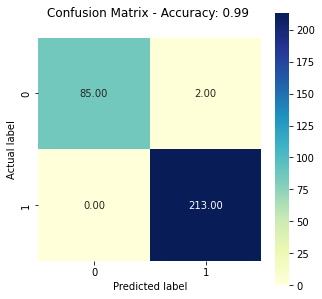

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt=".2f", square=True, cmap='YlGnBu');
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix - Accuracy: {round(accuracy, 2)} \n')
plt.show()

C'est vrai que la précision du modèle de K-Means est présque parfaite, mais comme avec K-NN, ce modèle est un peu dangereux car il a identifié deux faux billets comme vrais.

# 8 Final Application

In [ ]:
def detector_app(df):
  X = df.values
  y_pred_lgr = lgr_model.predict(X)
  y_pred_knn = knn_model.predict(X)
  y_pred_kmeans = kmeans_model.predict(X)
  
  results = df.copy()
  results['is_genuine_lgr'] = y_pred_lgr
  results['is_genuine_knn'] = y_pred_knn
  results['is_genuine_kmeans'] = y_pred_kmeans

  return results


## 8.1 Data Loading

In [ ]:
data_prod = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OC-DAN/P10/billets_production.csv", na_values = missing_values)

In [ ]:
data_prod.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.760,104.010,103.540,5.210,3.300,111.420,A_1
1,171.870,104.170,104.130,6.000,3.310,112.090,A_2
2,172.000,104.580,104.290,4.990,3.390,111.570,A_3
3,172.490,104.550,104.340,4.440,3.030,113.200,A_4
4,171.650,103.630,103.560,3.770,3.160,113.330,A_5


## 8.2 Data Preprocessing

In [ ]:
columns = ['length', 'margin_low', 'margin_up', 'height_right', 'height_left', 'diagonal']
df_prod = data_prod[columns]
df_prod

,length,margin_low,margin_up,height_right,height_left,diagonal
0,111.420,5.210,3.300,103.540,104.010,171.760
1,112.090,6.000,3.310,104.130,104.170,171.870
2,111.570,4.990,3.390,104.290,104.580,172.000
3,113.200,4.440,3.030,104.340,104.550,172.490
4,113.330,3.770,3.160,103.560,103.630,171.650


## 8.3 Execution

In [ ]:
detector_app(df_prod)

,length,margin_low,margin_up,height_right,height_left,diagonal,is_genuine_lgr,is_genuine_knn,is_genuine_kmeans
0,111.420,5.210,3.300,103.540,104.010,171.760,False,False,0
1,112.090,6.000,3.310,104.130,104.170,171.870,False,False,0
2,111.570,4.990,3.390,104.290,104.580,172.000,False,False,0
3,113.200,4.440,3.030,104.340,104.550,172.490,True,True,1
4,113.330,3.770,3.160,103.560,103.630,171.650,True,True,1
